<a href="https://colab.research.google.com/github/michaeledge27/CSCI290/blob/main/notebooks/kMeansClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [97]:
iris = load_iris()

In [98]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [99]:
df["species"] = iris.target

In [100]:
target_names = {
    0: "setosa",
    1: "versicolor",
    2: "virginica"
}

df["species_name"] = df["species"].map(target_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [103]:
df2 = df.copy().drop(columns=["species_name"])
df2

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


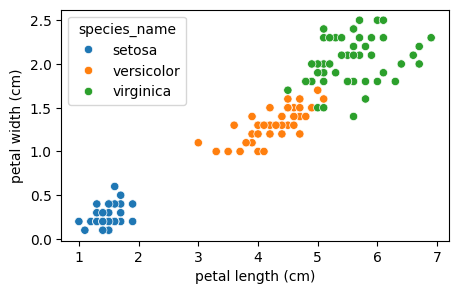

In [59]:
plt.figure(figsize=(5, 3))
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "species_name");

In [60]:
df = df.drop(columns=["species", "species_name"])

In [61]:
df[['current_cluster']] = -1
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,-1
1,4.9,3.0,1.4,0.2,-1
2,4.7,3.2,1.3,0.2,-1
3,4.6,3.1,1.5,0.2,-1
4,5.0,3.6,1.4,0.2,-1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,-1
146,6.3,2.5,5.0,1.9,-1
147,6.5,3.0,5.2,2.0,-1
148,6.2,3.4,5.4,2.3,-1


# k-Means Algorithm

In [62]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [63]:
# return random sample of k initial centroids
def get_random_centroids(df, k):
    return df.sample(k)[df.columns[:-1]]

In [64]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
99,5.7,2.8,4.1,1.3
37,4.9,3.6,1.4,0.1
17,5.1,3.5,1.4,0.3


In [65]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
4,5.0,3.6,1.4,0.2
141,6.9,3.1,5.1,2.3
77,6.7,3.0,5.0,1.7


In [66]:
# compare old centroids to new centroids to see if the algorithm has converged yet
# return true if new_centroids is equal to old_centroids, false otherwise
def check_new_centroids(old_centroids, new_centroids):
    if old_centroids.empty:
        return False  # Return False at start of loop
    return np.allclose(old_centroids.values, new_centroids.values, atol=0.001)

In [67]:
def update_centroids(df):
    return df.groupby("current_cluster").mean()[df.columns[:-1]]


In [68]:
# plot data and centroids for each iteration
def plot_clusters(df, centroids, iteration):
    plt.figure(figsize=(5, 3))

    # Plot each cluster
    sns.scatterplot(x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "current_cluster");

    # Plot the centroids
    plt.scatter(
        centroids["petal length (cm)"], centroids["petal width (cm)"],
        color="red", marker="X", s=200, label="Centroids"
    )

    plt.title(f'Iteration {iteration}')
    plt.xlabel("petal length (cm)")
    plt.ylabel("petal width (cm)")
    plt.legend()
    plt.show()
    plt.pause(1)
    clear_output(wait=True)


In [69]:
def get_cluster(df, centroids, plot=True):
    # initialize old centroids as an empty dataframe
    old_centroids = pd.DataFrame()
    # keep track of what iteration we are on for plotting
    iteration = 0
    # run iteratively while the new centroids are different from the old ones
    while not check_new_centroids(old_centroids, centroids):
        # update the old centroids
        old_centroids = centroids.copy()
        # iterate over each point in the data frame
        for i in df.index:
            # store distances from current point to each centroid
            distances = []
            # iterate over each centroid
            for _, centroid in centroids.iterrows():
                # calculate euclidean distance from current point to current centroid
                distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], centroid))
            # assign the point to the cluster with the closest centroid
            closest_cluster = np.argmin(distances)
            df.loc[i, 'current_cluster'] = closest_cluster

        if plot:
          # plot clusters and centroids
          plot_clusters(df, centroids, iteration)
        #update centroids
        centroids = update_centroids(df)
        iteration += 1
    return df


In [70]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
39,5.1,3.4,1.5,0.2
35,5.0,3.2,1.2,0.2
120,6.9,3.2,5.7,2.3


In [71]:
get_cluster(df, get_random_centroids(df, 3))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,0
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


# Accuracy

In [91]:
def calculate_accuracy(df, clustered_df, target='species'):
    accuracy = 0
    for i in df.index:
        if df.loc[i, target] == clustered_df.loc[i, 'current_cluster']:
            accuracy += 1
    return accuracy / len(df)

# Inertia Method

In [72]:
def get_inertia(df, centroids):
    # initialize as 0
    inertia = 0
    # loop through each point
    for i in df.index:
        # get cluster assignment
        cluster = df.loc[i, 'current_cluster']
        # calculate euclidean distance between the point and its assigned centroid
        distance = euclidean_distance(df.loc[i, df.columns[:-1]], centroids.loc[cluster])
        # add the squared distance to the total inertia
        inertia += distance**2
    return inertia

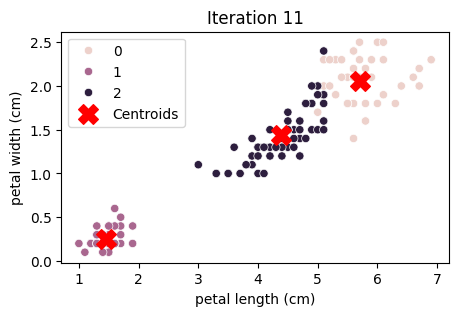

In [73]:
clustered_df = get_cluster(df, get_random_centroids(df, 3))

In [74]:
inertia = get_inertia(clustered_df, update_centroids(clustered_df))
inertia

78.85566582597727

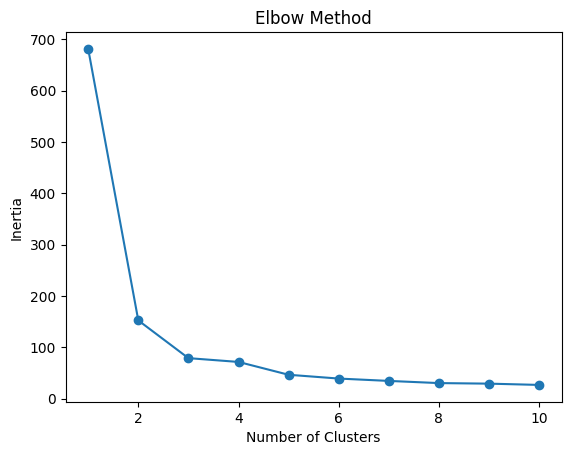

In [75]:
inertias = []
for i in range(1, 11):
    centroids = get_random_centroids(df, i)
    clustered_df = get_cluster(df, centroids, plot=False)
    inertia = get_inertia(clustered_df, update_centroids(clustered_df))
    inertias.append(inertia)


plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Initialize Centroids

In [76]:
def initialize_centroids(df, k):
    # initialize list to hold k centroids
    centroids = []
    # randomly select first centroid
    first_centroid = df.sample(1).iloc[0]
    # add it to the centroid list
    centroids.append(first_centroid)
    # get remaining k-1 centroids
    for i in range(1, k):     # k is exclusive
        # initialize list to hold distances from new centroids to the first centroid
        distances = []
        # loop through each point in the data frame
        for i in df.index:
            point = df.loc[i, df.columns[:-1]]
            # Calculate the distance from the current point to each centroid
            min_distance = min(euclidean_distance(point, centroid) for centroid in centroids)
            distances.append(min_distance**2)  # Append squared distance
        # compute probabilities
        probabilities = distances / np.sum(distances)
        # select new centroid
        new_centroid = df.sample(1, weights=probabilities).iloc[0]
        # add new centroid to list
        centroids.append(new_centroid)

    return pd.DataFrame(centroids, columns=df.columns[:-1])

In [77]:
get_cluster(df, initialize_centroids(df, 3))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,0
148,6.2,3.4,5.4,2.3,0


# Silhouette Coefficients

In [78]:
# calculate mean inter cluster distance (a_i)
def mean_icd(df, point_index):
    distances = []
    # get the current cluster of the point
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all points in the current cluster
    cluster_points = df[df['current_cluster'] == current_cluster]
    # loop through all points in current cluster
    for i in cluster_points.index:
        # exclude the point itself
        if i != point_index:
            # calculate and append mean distance between the current point and all other points
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))

    return np.mean(distances) if distances else 0


In [79]:
# calculate mean nearest cluster distance (b_i)
def mean_ncd(df, point_index):
    total_distances = []
    # get the current cluster
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all other clusters
    other_clusters = df[df['current_cluster'] != current_cluster]
    # loop through each unique cluster in other_clusters
    for cluster in other_clusters['current_cluster'].unique():
        # get all points belonging to the cluster being considered
        cluster_points = df[df['current_cluster'] == cluster]
        # compute distance to all points in the current cluster
        distances = []
        for i in cluster_points.index:
            # calculate distance between this point and each point in the current cluster
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))
        # calculate mean distance to the current cluster
        total_distances.append(np.mean(distances))
    # return minimum mean distance among all clusters
    return min(total_distances)


In [80]:
def get_silhouette_coefficients(df):
    # store coefficients for all points
    silhouette_coefficients = []
    # loop through each point
    for i in df.index:
        # calculate mean inter cluster distance
        a = mean_icd(df, i)
        # calculate mean nearest cluster distance
        b = mean_ncd(df, i)
        # compute silhouette coefficient for each point
        silhouette_coefficients.append((b - a) / max(a, b))
    # return silhouette coefficients for all points
    return silhouette_coefficients


In [81]:
dataframe = get_cluster(df, initialize_centroids(df, 3), plot=False)

In [82]:
sil_score = get_silhouette_coefficients(dataframe)
sil_score

[0.8525819140205704,
 0.8149163007101907,
 0.8287965938893569,
 0.8043519882689957,
 0.8489177360033157,
 0.7477613962963564,
 0.821097569610566,
 0.8534933989521796,
 0.7512780590515931,
 0.8247519865331362,
 0.802695246572614,
 0.8354039626463738,
 0.8099671646009372,
 0.7453563734234508,
 0.7022403826070853,
 0.6433885561984404,
 0.7752685651876086,
 0.8506327208409312,
 0.7063674196516304,
 0.8198745822576176,
 0.7836412212689903,
 0.8254666534416234,
 0.792444118680519,
 0.7934525051509806,
 0.774264789045963,
 0.79799563536788,
 0.8329610812319288,
 0.8416213636789367,
 0.8432504615748125,
 0.8172340158296378,
 0.8145665012246183,
 0.7984982634670572,
 0.7622787927898014,
 0.7218460460768069,
 0.8282286634845444,
 0.8317947720441432,
 0.793740242622182,
 0.8414804158191312,
 0.7677936327038021,
 0.8499260260504251,
 0.849023873641911,
 0.637674186943994,
 0.7858919511074565,
 0.7996316748465924,
 0.7462943653514115,
 0.8091517165489608,
 0.8129556483150573,
 0.8184401068200137,
 

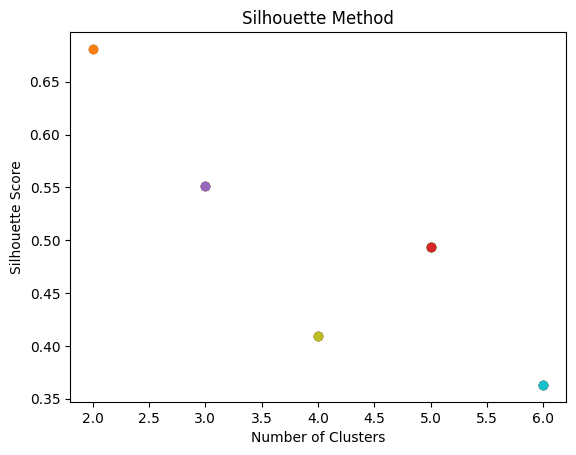

In [84]:
for k in range(2, 7):

    centroids = initialize_centroids(df, k)
    clustered_df = get_cluster(df, centroids, plot=False)
    for cluster in clustered_df['current_cluster'].unique():
        cluster_points = clustered_df[clustered_df['current_cluster'] == cluster]
        sil_coefficients = get_silhouette_coefficients(cluster)
    sil_score = np.mean(sil_coefficients)


    # centroids = initialize_centroids(df, k)
    # clustered_df = get_cluster(df, centroids, plot=False)
    #     cluster_points = clustered_df[clustered_df['current_cluster'] == cluster]
    # sil_coefficients = get_silhouette_coefficients(clustered_df)
    # sil_score = np.mean(sil_coefficients)
    # sil_coefficients.sort()
    # plt.plot(k, sil_score, marker='o')

plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

keep track/figure out which cluster each coefficient is assigned to, turn it into a dataframe and plot coefficients for each cluster using groupby and the mean of the coefficients for each value of k